# Imports


In [1]:
from pathlib import Path

from IPython.core.display import display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import mne_connectivity
from tqdm.notebook import tqdm
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import pearsonr

import acareeg
from infant_connectivity import load_connectivity_data, get_demo_data, label_outliers, \
    plot_outliers, get_ind_both_time_point, logit, add_bin_dist

# Global variables and configuration

In [2]:
palette = sns.color_palette(["green", "orange", "red"])

#con_path = Path("/Volumes/usc_data/ElementSE/eegip/con_paper/")
con_path = Path("/Users/christian/Documents/con_paper/")

plt.rcParams['figure.facecolor'] = 'white'

# Loading data

In [4]:
band = "broadband"

#con_data = load_connectivity_data(con_path, band=band, con_name="ciplv", lambda2=1e-4)
#demo_data = get_demo_data(force_download=False)
#dat = con_data.merge(demo_data, on=["subject_no", "dataset"])

dat = pd.read_csv("analysis_data.csv")  # From notebok 2.1

# Plotting connectivity graphs

In [16]:
# Keeping only subject with recordings for at both 6 and 12 months because
# we will average across age and we want to avoid differences in age
# between groups to affect the result
dat = dat[get_ind_both_time_point(dat)]

dat.groupby(["subject", "group"]).mean().groupby("group").count()["age"]

group
Control      54
HRA-ASD      16
HRA-noASD    42
Name: age, dtype: int64

In [5]:
# Average across age
tmp = dat.groupby(["region1", "region2", "site", "group", "subject", "sex"],
                  observed=True).mean().reset_index()

tmp2 = tmp.copy()
tmp2.region2 = tmp.region1
tmp2.region1 = tmp.region2
tmp3 = pd.concat([tmp, tmp2])

mats = {}
for group in np.unique(tmp3.group):
    tmp4 = tmp3[tmp3.group == group].groupby(["region1", "region2", "site", "age"]).mean()["log_con"]
    tmp4 = tmp4.reset_index().groupby(["region1", "region2"]).mean().reset_index().drop(columns=["age"])
    mats[group] = tmp4.pivot_table(index="region1", columns="region2")
    mats[group][np.eye(len(tmp4.region1.unique())).astype(bool)] = 0

In [6]:
def plot_con_graph(mat, n_lines=300, subjects_dir = ".", **kwargs):
    # Get labels for FreeSurfer 'aparc' cortical parcellation with 34 labels/hemi
    labels = acareeg.infantmodels.get_template_labels(age=12, parc='aparc', subjects_dir=subjects_dir)
    label_colors = [label.color for label in labels]

    # First, we reorder the labels based on their location in the left hemi
    label_names = [label.name for label in labels]
    label_names = [name for name in label_names if name in mat.columns and "parahippocampal" not in name]
    con_mat = mat.loc[label_names, label_names].values

    lh_labels = [name for name in label_names if name.endswith('lh')]

    # Get the y-location of the label
    label_ypos = list()
    for name in lh_labels:
        idx = label_names.index(name)
        ypos = np.mean(labels[idx].pos[:, 1])
        label_ypos.append(ypos)

    # Reorder the labels based on their location
    lh_labels = [label for (yp, label) in sorted(zip(label_ypos, lh_labels))]

    # For the right hemi
    rh_labels = [label[:-2] + 'rh' for label in lh_labels if label in label_names]

    # Save the plot order and create a circular layout
    node_order = list()
    node_order.extend(lh_labels[::-1])  # reverse the order
    node_order.extend(rh_labels)

    node_angles = mne.viz.circular_layout(label_names, node_order, start_pos=90,
                                  group_boundaries=[0, len(label_names) / 2])
    
    # Plot the graph using node colors from the FreeSurfer parcellation. We only
    # show the 300 strongest connections.
    return mne_connectivity.viz.plot_connectivity_circle(con_mat, [""]*len(label_names), 
                                            n_lines=n_lines,
                                            node_angles=node_angles, node_colors=label_colors,
                                            **kwargs)[0]

Reading labels from parcellation...
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/lh.aparc.annot
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/rh.aparc.annot


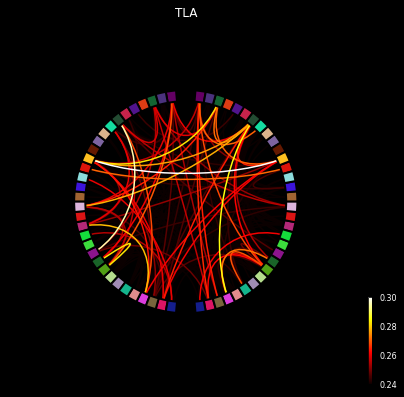

In [7]:
fig_abs = plot_con_graph(np.exp(mats['Control']["log_con"]),  #vmin=0.05, vmax=0.08, 
                     vmin=0.24, vmax=0.3, 
                     title="TLA")
fig_abs.savefig("images/" + "con_plot_control.png", dpi=300)

Reading labels from parcellation...
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/lh.aparc.annot
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/rh.aparc.annot


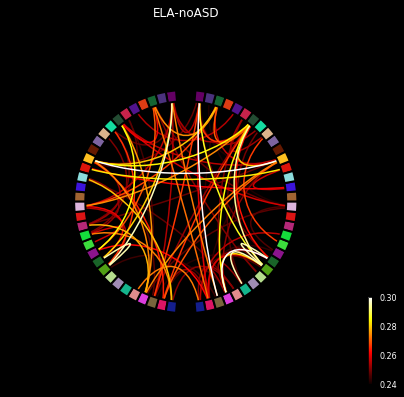

In [8]:
fig = plot_con_graph(np.exp(mats['HRA-noASD']["log_con"]), 
               vmin=0.24, vmax=0.3, 
               n_lines=100, title="ELA-noASD")
fig.savefig("images/" + "con_plot_HRA-noASD.png", dpi=300)



Reading labels from parcellation...
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/lh.aparc.annot
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/rh.aparc.annot


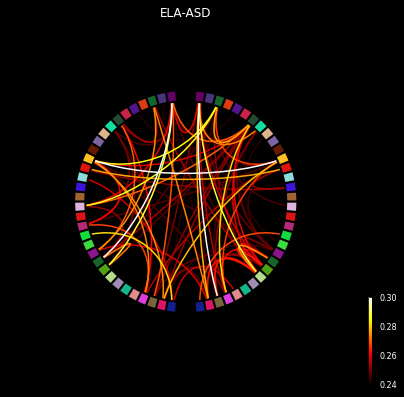

In [9]:
fig = plot_con_graph(np.exp(mats['HRA-ASD']["log_con"]), 
               vmin=0.24, vmax=0.3,
               n_lines=100, title="ELA-ASD")
fig.savefig("images/" + "con_plot_HRA-ASD.png", dpi=300)



Reading labels from parcellation...
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/lh.aparc.annot
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/rh.aparc.annot


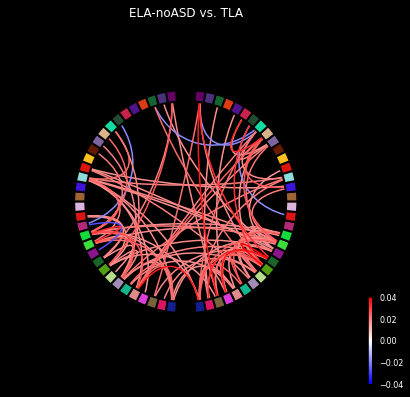

In [10]:
fig_diff = plot_con_graph(np.exp(mats['HRA-noASD']["log_con"]) - np.exp(mats['Control']["log_con"]), 
               vmin=-0.04, vmax=0.04, 
               n_lines=100, colormap="bwr", title="ELA-noASD vs. TLA")
fig_diff.savefig("images/" + "con_plot_HRA-Control.png", dpi=300)



Reading labels from parcellation...
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/lh.aparc.annot
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/rh.aparc.annot


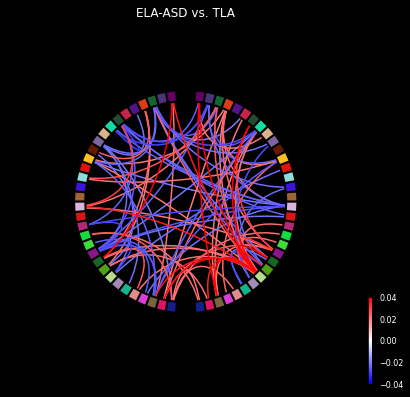

In [11]:
fig = plot_con_graph(np.exp(mats['HRA-ASD']["log_con"]) - np.exp(mats['Control']["log_con"]), 
               vmin=-0.04, vmax=0.04, 
               n_lines=100, colormap="bwr", title="ELA-ASD vs. TLA")
fig.savefig("images/" + "con_plot_ASD-Control.png", dpi=300)



con_plot_control.png
con_plot_HRA-noASD.png
con_plot_HRA-ASD.png

con_plot_HRA-Control.png
con_plot_ASD-Control.png


/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_29009/1476182307.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


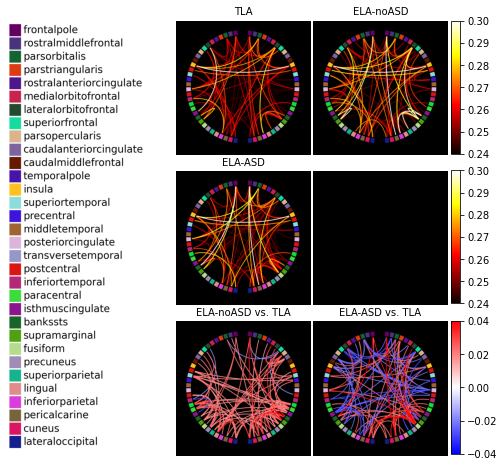

In [12]:
from itertools import product
import matplotlib as mpl


fig = plt.figure(figsize=(8.3, 8))

img_file_names = ["con_plot_control.png", "con_plot_HRA-noASD.png", "con_plot_HRA-ASD.png", "", "con_plot_HRA-Control.png", "con_plot_ASD-Control.png"]
titles = ["TLA", "ELA-noASD", "ELA-ASD", "", "ELA-noASD vs. TLA", "ELA-ASD vs. TLA"]

gs = fig.add_gridspec(3, 3,  width_ratios=(7, 5, 5), wspace=0.01, hspace=0.12) #height_ratios=(2, 7),
                      #left=0.1, right=0.9, bottom=0.1, top=0.9,
                      #wspace=0.05, hspace=0.05)

axes = np.array([fig.add_subplot(gs[i, j+1]) for i, j in product(range(3), range(2))]).ravel()

for ax, file_name, title in zip(axes, img_file_names, titles):
    print(file_name)
    if file_name == "":
        img[..., :3] = 0
    else:
        img = plt.imread("images/" + file_name)[650:-650, 500:-800]
    ax.imshow(img)
    ax.axis(False)
    ax.set_title(title, size=10)

    
#ax =  fig.add_subplot(gs[0, -1])
ax = fig.add_axes([0.905, 0.649, 0.015, 0.231])
cmap = mpl.cm.hot
norm = mpl.colors.Normalize(vmin=0.24, vmax=0.3)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, extendfrac=0.04)    
    
ax = fig.add_axes([0.905, 0.389, 0.015, 0.231])    
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, extendfrac=0.04)   
    
ax = fig.add_axes([0.905, 0.128, 0.015, 0.231])
cmap = mpl.cm.bwr
norm = mpl.colors.Normalize(vmin=-0.04, vmax=0.04)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, extendfrac=0.04)    
        
    
#ax.legend(bbox_to_anchor=(1.1, 1.05))    
    
ax_legend = fig.add_subplot(gs[:, 0]) 
img = plt.imread("legend.png")
ax_legend.imshow(img)
ax_legend.axis(False)

fig.savefig("images/" + "con_plot_all.png", dpi=300)
fig.tight_layout()

/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_29009/2574674169.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["log_con"] = logit(tmp.con)


Reading labels from parcellation...
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/lh.aparc.annot
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/rh.aparc.annot


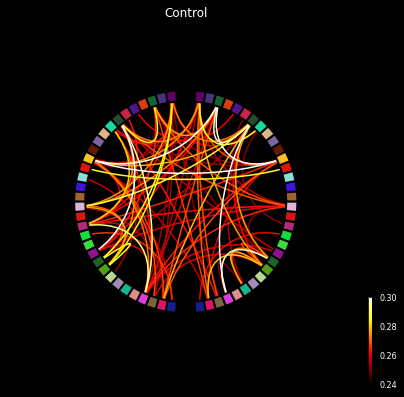

Reading labels from parcellation...
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/lh.aparc.annot
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/rh.aparc.annot


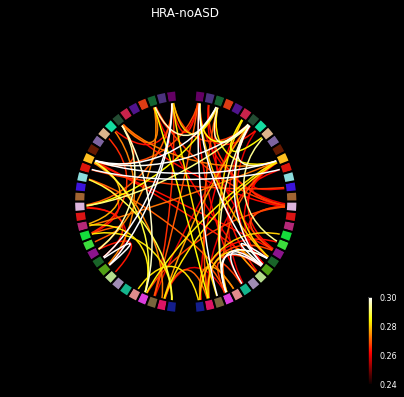

Reading labels from parcellation...
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/lh.aparc.annot
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/rh.aparc.annot


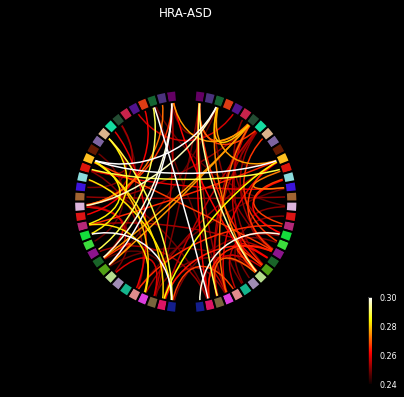

Reading labels from parcellation...
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/lh.aparc.annot
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/rh.aparc.annot


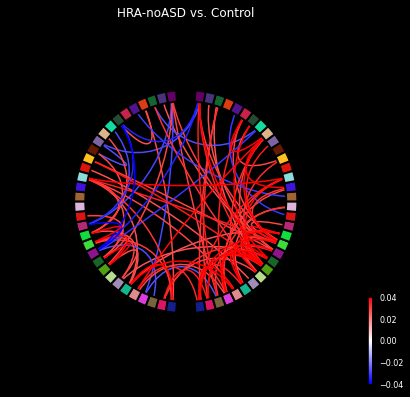

Reading labels from parcellation...
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/lh.aparc.annot
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/rh.aparc.annot


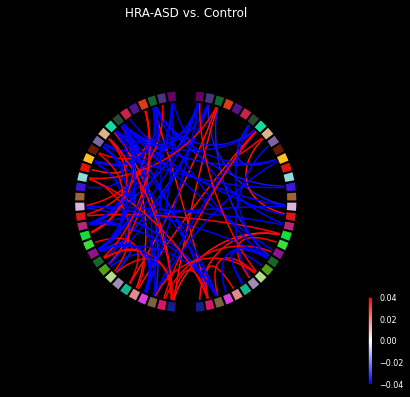

con_plot_control_6.png
con_plot_HRA-noASD_6.png
con_plot_HRA-ASD_6.png

con_plot_HRA-Control_6.png
con_plot_ASD-Control_6.png


/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_29009/2574674169.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_29009/2574674169.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["log_con"] = logit(tmp.con)


Reading labels from parcellation...
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/lh.aparc.annot
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/rh.aparc.annot


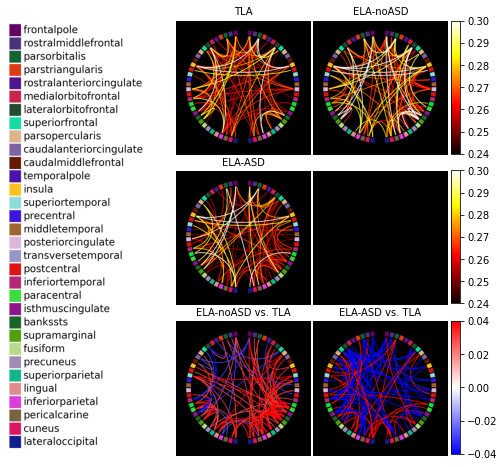

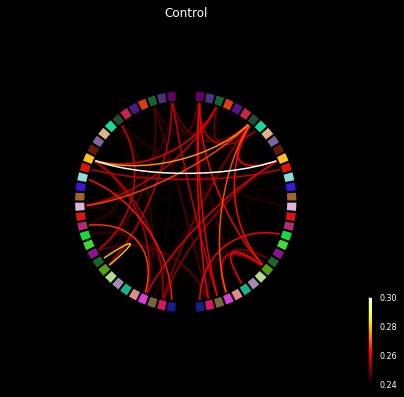

Reading labels from parcellation...
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/lh.aparc.annot
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/rh.aparc.annot


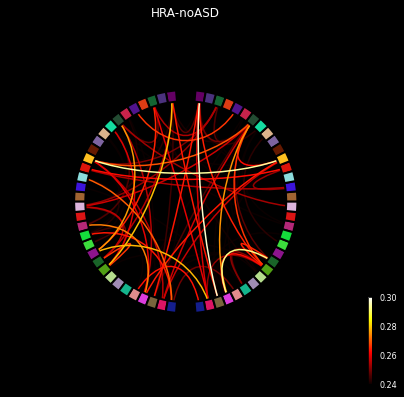

Reading labels from parcellation...
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/lh.aparc.annot
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/rh.aparc.annot


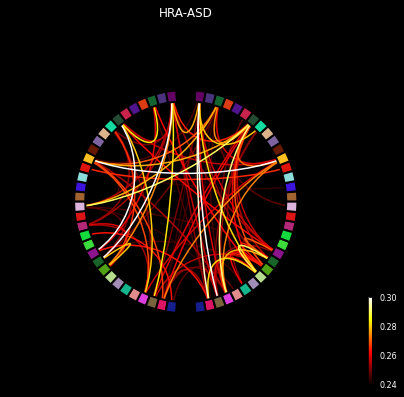

Reading labels from parcellation...
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/lh.aparc.annot
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/rh.aparc.annot


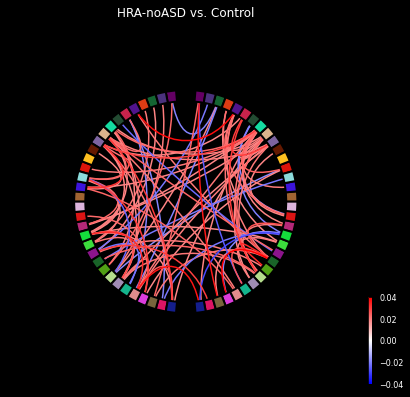

Reading labels from parcellation...
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/lh.aparc.annot
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/rh.aparc.annot


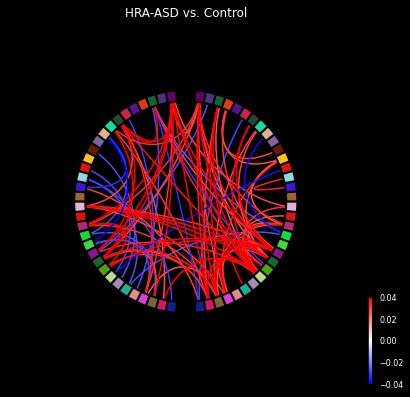

con_plot_control_12.png
con_plot_HRA-noASD_12.png
con_plot_HRA-ASD_12.png

con_plot_HRA-Control_12.png
con_plot_ASD-Control_12.png


/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_29009/2574674169.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


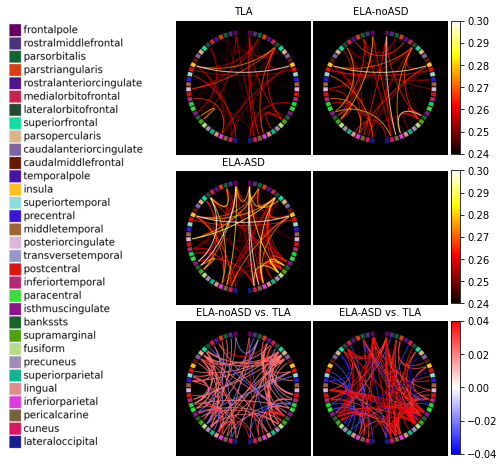

In [13]:
for age in [6, 12]:
    
    tmp = dat[(~dat.outliers_logit) & (dat.age == age)]
    tmp["log_con"] = logit(tmp.con)

    tmp2 = tmp.copy()
    tmp2.region2 = tmp.region1
    tmp2.region1 = tmp.region2
    tmp3 = pd.concat([tmp, tmp2])

    mats = {}
    for group in np.unique(tmp3.group):
        tmp4 = tmp3[tmp3.group == group].groupby(["region1", "region2", "site", "age"]).mean()["log_con"]
        tmp4 = tmp4.reset_index().groupby(["region1", "region2"]).mean().reset_index().drop(columns=["age"])
        mats[group] = tmp4.pivot_table(index="region1", columns="region2")
        mats[group][np.eye(len(tmp4.region1.unique())).astype(bool)] = 0    


    for group in ['Control', 'HRA-noASD', 'HRA-ASD']:
        plot_con_graph(np.exp(mats[group]["log_con"]), vmin=0.24, vmax=0.3,
                       n_lines=100, title=group).savefig("images/" + f"con_plot_{group}_{age}.png", dpi=300)

    plot_con_graph(np.exp(mats['HRA-noASD']["log_con"]) - np.exp(mats['Control']["log_con"]), vmin=-0.04, vmax=0.04, 
               n_lines=100, colormap="bwr", title="HRA-noASD vs. Control").savefig("images/" + f"con_plot_HRA-Control_{age}.png", dpi=300)

    plot_con_graph(np.exp(mats['HRA-ASD']["log_con"]) - np.exp(mats['Control']["log_con"]), vmin=-0.04, vmax=0.04, 
               n_lines=100, colormap="bwr", title="HRA-ASD vs. Control").savefig("images/" + f"con_plot_ASD-Control_{age}.png", dpi=300)
    
    
    fig = plt.figure(figsize=(8.3, 8))

    img_file_names = [f"con_plot_control_{age}.png", f"con_plot_HRA-noASD_{age}.png", f"con_plot_HRA-ASD_{age}.png", 
                      "", f"con_plot_HRA-Control_{age}.png", f"con_plot_ASD-Control_{age}.png"]
    titles = ["TLA", "ELA-noASD", "ELA-ASD", "", "ELA-noASD vs. TLA", "ELA-ASD vs. TLA"]

    gs = fig.add_gridspec(3, 3,  width_ratios=(7, 5, 5), wspace=0.01, hspace=0.12) #height_ratios=(2, 7),
                          #left=0.1, right=0.9, bottom=0.1, top=0.9,
                          #wspace=0.05, hspace=0.05)

    axes = np.array([fig.add_subplot(gs[i, j+1]) for i, j in product(range(3), range(2))]).ravel()

    for ax, file_name, title in zip(axes, img_file_names, titles):
        print(file_name)
        if file_name == "":
            img[..., :3] = 0
        else:
            img = plt.imread("images/" + file_name)[650:-650, 500:-800]
        ax.imshow(img)
        ax.axis(False)
        ax.set_title(title, size=10)


    #ax =  fig.add_subplot(gs[0, -1])
    ax = fig.add_axes([0.905, 0.649, 0.015, 0.231])
    cmap = mpl.cm.hot
    norm = mpl.colors.Normalize(vmin=0.24, vmax=0.3)
    cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, extendfrac=0.04)    

    ax = fig.add_axes([0.905, 0.389, 0.015, 0.231])    
    cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, extendfrac=0.04)   

    ax = fig.add_axes([0.905, 0.128, 0.015, 0.231])
    cmap = mpl.cm.bwr
    norm = mpl.colors.Normalize(vmin=-0.04, vmax=0.04)
    cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, extendfrac=0.04)    


    #ax.legend(bbox_to_anchor=(1.1, 1.05))    

    ax_legend = fig.add_subplot(gs[:, 0]) 
    img = plt.imread("legend.png")
    ax_legend.imshow(img)
    ax_legend.axis(False)

    fig.savefig("images/" + f"con_plot_all_{age}.png", dpi=300)
    fig.tight_layout()    

    